In [382]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import tools      # importe le module (si non importé)
import tools_ay
import torch.nn.functional as F
importlib.reload(tools)
importlib.reload(tools_ay)

# ré-affecter les fonctions si tu avais utilisé `from tools import ...`
setInitialValues = tools.setInitialValues
CSC = tools.CSC
CSC_l0 = tools.CSC_l0
CDU = tools.CDU
IPU = tools.IPU
PerCDU = tools.PerCDU
time_warping_f = tools.time_warping_f
CSC_l0_NMS = tools.CSC_l0_NMS

setInitialValues_ay = tools_ay.setInitialValues
CSC_ay = tools_ay.CSC
CDU_ay = tools_ay.CDU
CDU_Decorrelation = tools_ay.CDU_Decorrelation
setInitialValues_ay = tools_ay.setInitialValues

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


In [383]:
FOLDER = "../../Immersion Hopital/497-main/GaitData"
COLUMN_NAMES = ['TOX', 'TAX', 'TAY', 'RAV', 'RAZ', 'RRY', 'LAV', 'LAZ', 'LRY']

def load_metadata(subject, trial):
    code = f"{subject}-{trial}"
    with open(os.path.join(FOLDER, code + ".json")) as f:
        return json.load(f)

def load_XSens(filename):
    signal = pd.read_csv(filename, delimiter="\t", skiprows=1, header=0)
    signal["PacketCounter"] = (signal["PacketCounter"] - signal["PacketCounter"][0]) / 100
    for axis in ["X","Y","Z"]:
        signal[f"FreeAcc_{axis}"] = signal[f"Acc_{axis}"] - np.mean(signal[f"Acc_{axis}"])
    return signal

def load_signal(subject, trial):
    code = f"{subject}-{trial}"
    base = os.path.join(FOLDER, code)
    signal_lb = load_XSens(base + "_lb.txt")
    signal_lf = load_XSens(base + "_lf.txt")
    signal_rf = load_XSens(base + "_rf.txt")
    t_max = min(len(signal_lb), len(signal_lf), len(signal_rf))
    signal_lb, signal_lf, signal_rf = signal_lb[:t_max], signal_lf[:t_max], signal_rf[:t_max]

    gyr_x = signal_lb['Gyr_X']
    angle_x_full = np.cumsum(gyr_x)/100
    a = np.median(angle_x_full[:len(angle_x_full)//2])
    z = np.median(angle_x_full[len(angle_x_full)//2:])
    angle_x_full = np.sign(z)*(angle_x_full - a)*180/abs(z)

    sig = {
        'Time': signal_lb["PacketCounter"],
        'TOX': angle_x_full,
        'TAX': signal_lb["Acc_X"],
        'TAY': signal_lb["Acc_Y"],
        'RAV': np.sqrt(signal_rf["FreeAcc_X"]**2 + signal_rf["FreeAcc_Y"]**2 + signal_rf["FreeAcc_Z"]**2),
        'RAZ': signal_rf["FreeAcc_Z"],
        'RRY': signal_rf["Gyr_Y"],
        'LAV': np.sqrt(signal_lf["FreeAcc_X"]**2 + signal_lf["FreeAcc_Y"]**2 + signal_lf["FreeAcc_Z"]**2),
        'LAZ': signal_lf["FreeAcc_Z"],
        'LRY': signal_lf["Gyr_Y"]
    }
    return pd.DataFrame(sig)

def show_plot_simple(signal, to_plot, sample_rate=100):
    n_samples = len(signal)
    tt = np.arange(n_samples)/sample_rate
    for dim_name in to_plot:
        plt.figure()
        plt.plot(tt, signal[dim_name])
        plt.xlabel("Time (s)")
        plt.ylabel("m/s²" if dim_name[1]=="A" else "deg/s")
        plt.title(dim_name)
        plt.show()


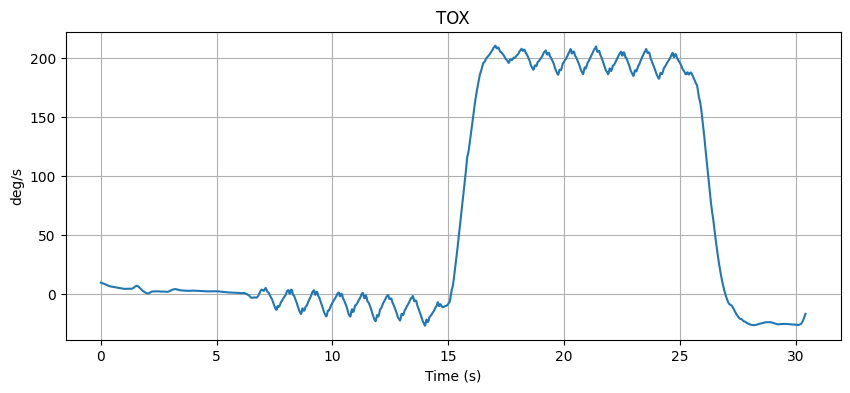

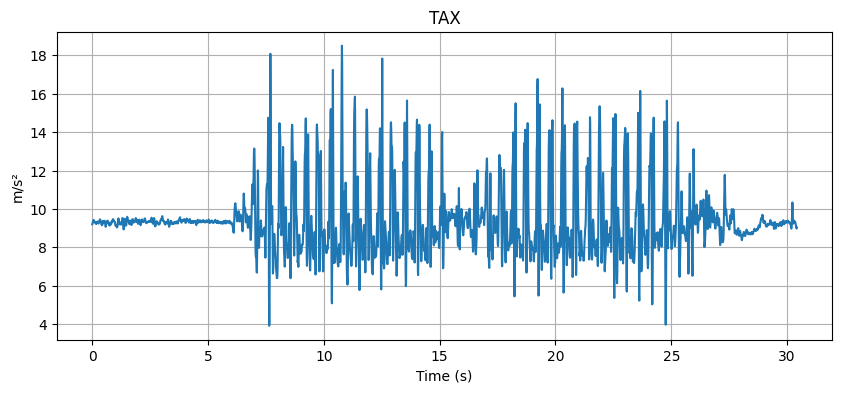

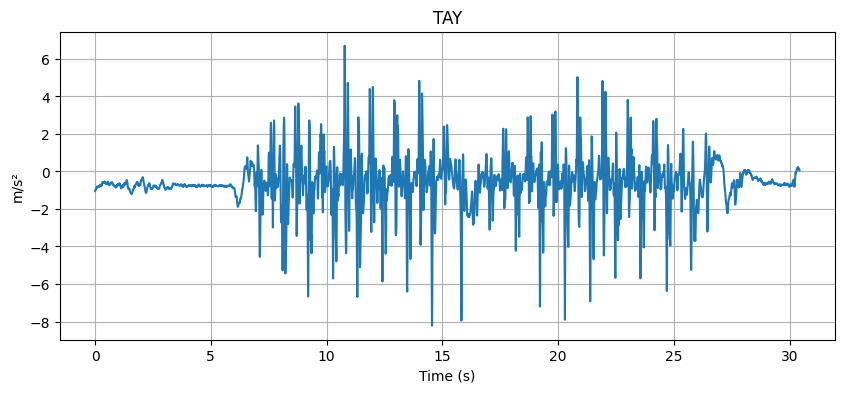

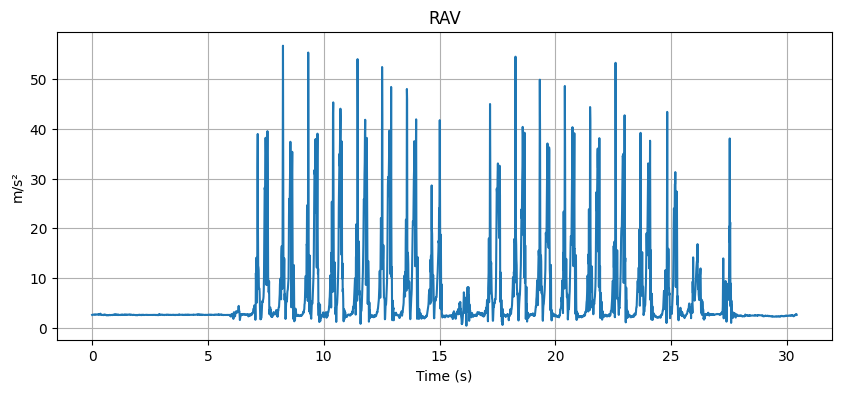

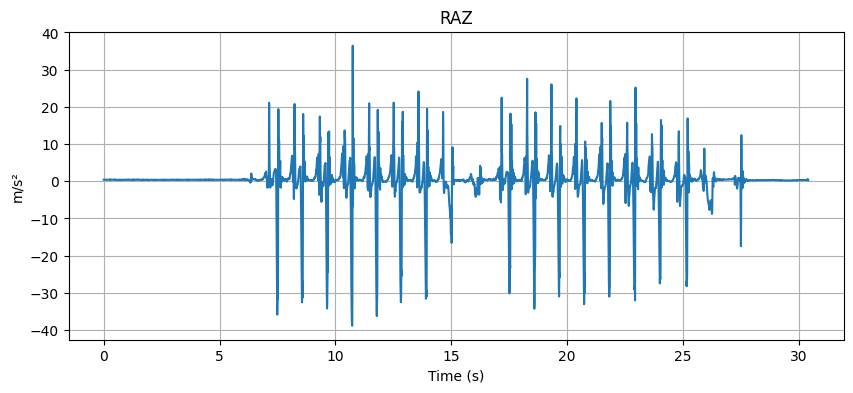

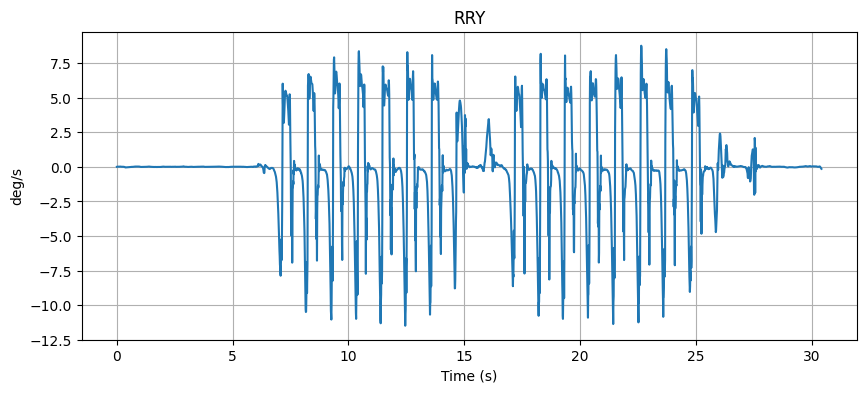

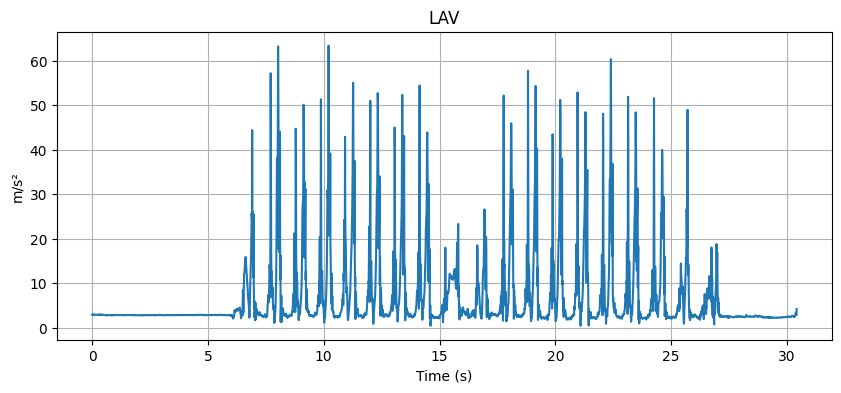

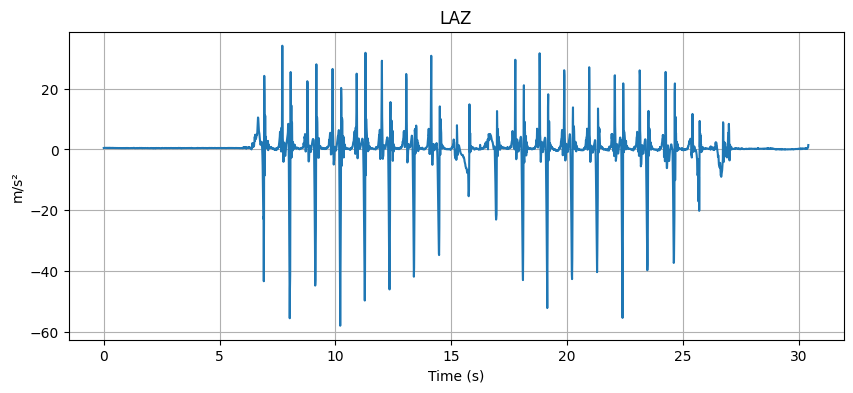

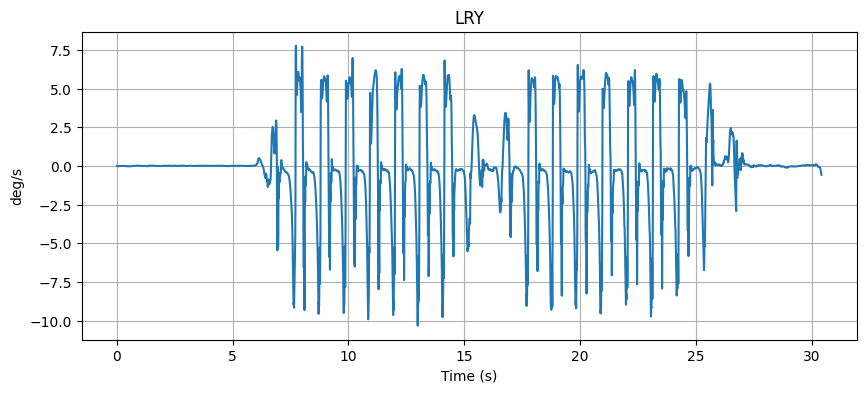

In [384]:
subject = 5
trial = 1
metadata = load_metadata(subject, trial)
signal = load_signal(subject, trial)

to_plot = ['TOX','TAX','TAY','RAV','RAZ','RRY','LAV','LAZ','LRY']
show_plot_simple(signal, to_plot)


In [385]:
def build_X(subjects, signal_names, trial=1):
    """
    Initialize X for multiple subjects and selected signals.

    Parameters:
    - subjects: list of int, the subject IDs to include
    - signal_names: list of str, the signal names to include (e.g., ['RAV','RAZ'])
    - trial: int, the trial number to use for each subject

    Returns:
    - X: torch.tensor of shape S x N x P
        S = number of subjects,
        N = number of time samples (truncated to the shortest signal),
        P = number of selected signals
    """
    import torch
    all_signals = []
    min_len = None

    for subj in subjects:
        sig_df = load_signal(subj, trial)
        sig = sig_df[signal_names].values  # shape: N_subject x P
        if min_len is None or len(sig) < min_len:
            min_len = len(sig)
        all_signals.append(sig)

    # truncate all signals to the same length
    truncated = [sig[:min_len] for sig in all_signals]

    # stack into a tensor of shape S x N x P
    X = torch.tensor(np.stack(truncated), dtype=torch.float32)
    return X





In [386]:
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['RAV','RAZ']   # select only two signals
X = build_X(subjects, signal_names, trial=1)
print(X.shape)  # should output (10, N, 2)
X = X[:, 500:1300, :]

X = X - X.mean(dim=1, keepdim=True)
X = X / (X.std(dim=1, keepdim=True) + 1e-8)


torch.Size([10, 2389, 2])


In [387]:
S, N, P = X.shape
# paramètres pour PerCDL
K = 2   # nombre d'atomes
L = 70  # longueur des atomes
M = 20  # taille des paramètres de personnalisation

Phi, Z, A = setInitialValues_ay(X,K,M,L)
print("Phi:", Phi.shape)
print("Z:", Z.shape)
print("A:", A.shape)


Phi: torch.Size([2, 70, 2])
Z: torch.Size([10, 2, 731])
A: torch.Size([10, 2, 20])


In [388]:
# Hyperparameters
n_iters = 100      # number of alternations
lambda_ = 10      # sparsity weight for CSC
step_size_z = 0.01 # gradient step for Z
step_size_phi = 0.01 # gradient step for Phi


for it in range(n_iters):
    # --- CSC step: update Z while keeping Phi fixed ---
    Z = CSC_l0_NMS(X, Z, Phi, lambda_,nms_radius=3)
    # --- CDU step: update Phi while keeping Z fixed ---
    Phi = CDU_ay(X, Z, Phi)

print("Learned dictionary atoms")

Learned dictionary atoms


# Visualisation des résultats

Cette cellule trace :
- les atomes appris (pour chaque canal),
- pour quelques sujets : signal original vs reconstruction et MSE,
- les cartes d'activations (Z) pour quelques sujets,
- les normes des atomes et checks NaN.

Affiche les graphiques inline. Ajuste `n_display` si tu veux plus/moins de sujets.

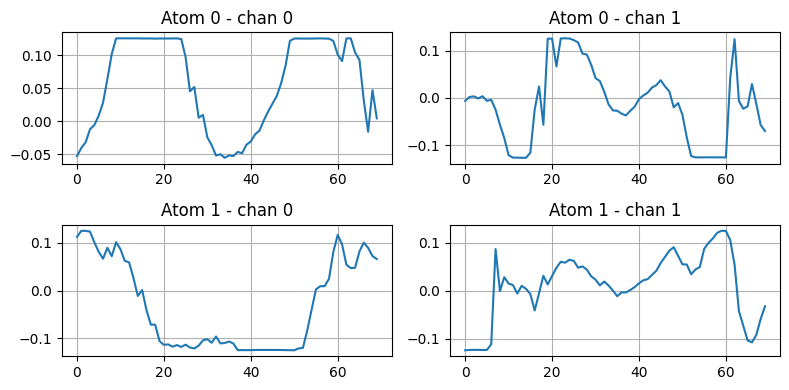

Subject 0 MSE: 5.101793e-01


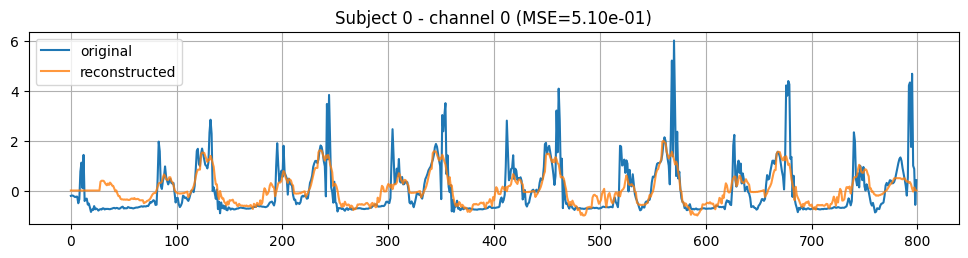

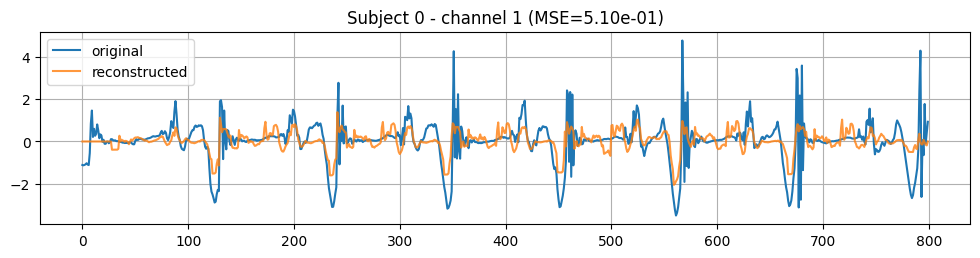

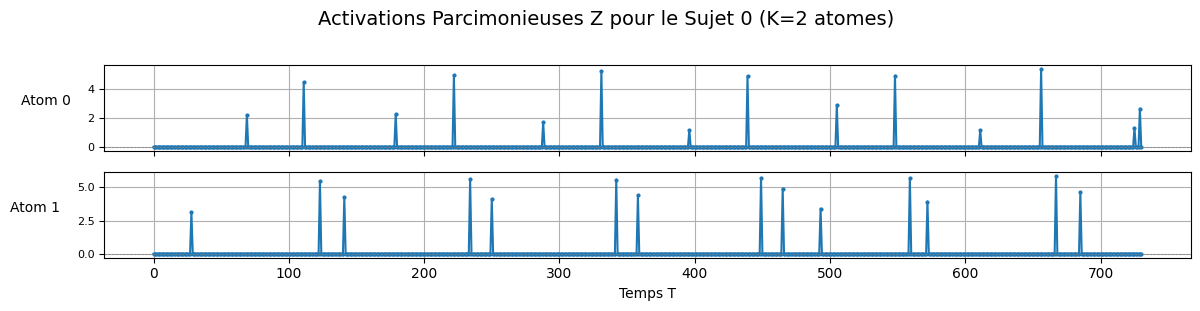

Atom norms: [1.         0.99999994]
MSE median: 4.991055e-01, mean: 5.227841e-01


In [389]:
# S'assurer que les variables existent
try:
    _ = Phi
    _ = Z
    _ = X
except NameError:
    raise RuntimeError("Les tenseurs Phi, Z, X doivent être définis avant d'exécuter cette cellule.")

# Copier sur CPU pour la visualisation
Phi_cpu = Phi.detach().cpu()
Z_cpu = Z.detach().cpu()
X_cpu = X.detach().cpu()

S, N, P = X_cpu.shape
K, L, P_phi = Phi_cpu.shape

# quick NaN check
if torch.isnan(Phi_cpu).any() or torch.isnan(Z_cpu).any() or torch.isnan(X_cpu).any():
    print("Attention : NaN détecté dans Phi / Z / X !")

# 1) Afficher les atomes (par canal)
fig, axs = plt.subplots(K, P, figsize=(4*P, 2*K))
for k in range(K):
    for p in range(P):
        if K == 1 and P == 1:
            ax = axs
        elif K == 1:
            ax = axs[p]
        elif P == 1:
            ax = axs[k]
        else:
            ax = axs[k, p]
        ax.plot(np.arange(L), Phi_cpu[k, :, p])
        ax.set_title(f'Atom {k} - chan {p}')
plt.tight_layout()
plt.show()

# 2) Reconstruction pour quelques sujets et calcul des MSE
n_display = min(1, S)
for s in range(n_display):
    z_s = Z_cpu[s].unsqueeze(0)  # 1 x K x T
    phi_conv = Phi_cpu.permute(0, 2, 1)  # K x P x L
    recon = F.conv_transpose1d(z_s, phi_conv, padding=0).squeeze(0).permute(1, 0)  # N x P
    recon = recon.numpy()
    x_s = X_cpu[s].numpy()

    if recon.shape != x_s.shape:
        print(f"Warning shape mismatch for subject {s}: recon {recon.shape} vs x {x_s.shape}")

    mse = ((x_s - recon) ** 2).mean()
    print(f'Subject {s} MSE: {mse:.6e}')

    for p in range(P):
        plt.figure(figsize=(12, 2.5))
        plt.plot(x_s[:, p], label='original')
        plt.plot(recon[:, p], label='reconstructed', alpha=0.8)
        plt.title(f'Subject {s} - channel {p} (MSE={mse:.2e})')
        plt.legend()
        plt.show()

# 3) Heatmap des activations Z (K x T) pour les mêmes sujets
T = Z_cpu.shape[2]
time_axis = np.arange(T)

for s in range(n_display):
    K = Z_cpu.shape[1] # Récupérer K
    
    # Définir la grille de subplots (K lignes, 1 colonne)
    # Taille ajustée pour avoir de la hauteur pour K courbes
    fig, axs = plt.subplots(K, 1, figsize=(12, 1.5 * K), sharex=True)
    
    if K == 1: # Gérer le cas K=1
        axs = [axs]
        
    for k in range(K):
        ax = axs[k]
        
        # Plot des activations pour l'atome k du sujet s
        # Z_cpu[s] est de forme (K, T)
        activations_k = Z_cpu[s, k, :].numpy()
        
        # On utilise stem ou plot avec des marqueurs discrets pour mieux voir les "diracs"
        # La fonction plot simple est souvent suffisante si la parcimonie est forte
        ax.plot(time_axis, activations_k, marker='.', linestyle='-', markersize=4, label=f'Atom {k}')
        
        # Mettre en évidence la non-négativité
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        
        # Titre pour l'axe Y
        ax.set_ylabel(f'Atom {k}', rotation=0, labelpad=30, fontsize=10)
        ax.tick_params(axis='y', labelsize=8)
        
        # Optionnel: définir l'axe y pour mieux visualiser les pics (si max(Z) est grand)
        # max_val = Z_cpu[s].max().item()
        # ax.set_ylim(-0.1 * max_val, max_val * 1.1)

    # Titre général et étiquette X
    fig.suptitle(f'Activations Parcimonieuses Z pour le Sujet {s} (K={K} atomes)', fontsize=14, y=1.02)
    axs[-1].set_xlabel('Temps T')
    
    plt.tight_layout(rect=[0, 0, 1, 1]) # Ajuster pour le suptitle
    plt.show()

# 4) Normes des atomes
norms = Phi_cpu.view(K, -1).norm(p=2, dim=1).numpy()
print('Atom norms:', norms)

# 5) Statistiques globales
recons = []
mses = []
for s in range(S):
    z_s = Z_cpu[s].unsqueeze(0)
    recon = F.conv_transpose1d(z_s, Phi_cpu.permute(0, 2, 1), padding=0).squeeze(0).permute(1, 0).numpy()
    x_s = X_cpu[s].numpy()
    if recon.shape == x_s.shape:
        mses.append(((x_s - recon) ** 2).mean())

if len(mses) > 0:
    print(f"MSE median: {np.median(mses):.6e}, mean: {np.mean(mses):.6e}")
else:
    print("Pas de MSE calculée (shape mismatch partout).")


In [390]:
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['RAV','RAZ']   # select only two signals
X = build_X(subjects, signal_names, trial=1)
print(X.shape)  # should output (10, N, 2)
X = X[:, 500:1300, :]

X = X - X.mean(dim=1, keepdim=True)
X = X / (X.std(dim=1, keepdim=True) + 1e-8)


torch.Size([10, 2389, 2])


In [391]:
S, N, P = X.shape
# paramètres pour PerCDL
K = 2   # nombre d'atomes
L = 70  # longueur des atomes
M = 20  # taille des paramètres de personnalisation

Phi, Z, A = setInitialValues(X,K,M,L)
print("Phi:", Phi.shape)
print("Z:", Z.shape)
print("A:", A.shape)


Phi: torch.Size([2, 70, 2])
Z: torch.Size([10, 2, 731])
A: torch.Size([10, 2, 20])


In [392]:
# Hyperparameters
n_iters = 100      # number of alternations
lambda_ = 8     # sparsity weight for CSC
step_size_z = 0.01 # gradient step for Z
step_size_phi = 0.01 # gradient step for Phi

n_perso = 100


for it in range(n_iters):
    # --- CSC step: update Z while keeping Phi fixed ---
    Z = CSC_l0_NMS(X, Z, Phi, lambda_,nms_radius=3)
    # --- CDU step: update Phi while keeping Z fixed ---
    Phi = CDU_ay(X, Z, Phi)


lambda_ = 7.5
for it in range(n_perso):
    A = IPU(X, Z, Phi, A)
    Z = CSC_l0_NMS(X, Z, Phi, lambda_,nms_radius=3)
    Phi = PerCDU(X, Z, Phi, A)


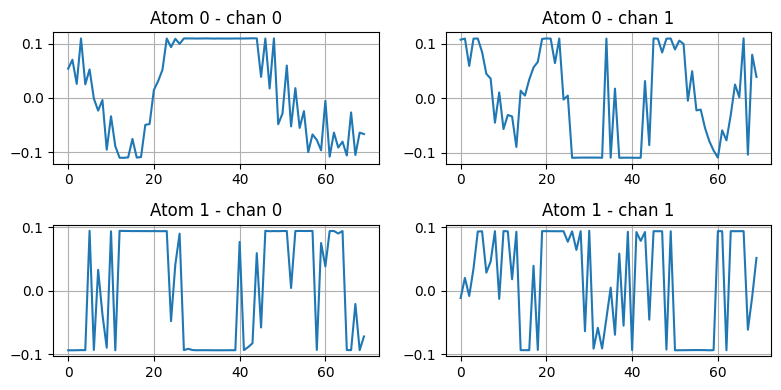

Subject 0 MSE: 6.076041e-01


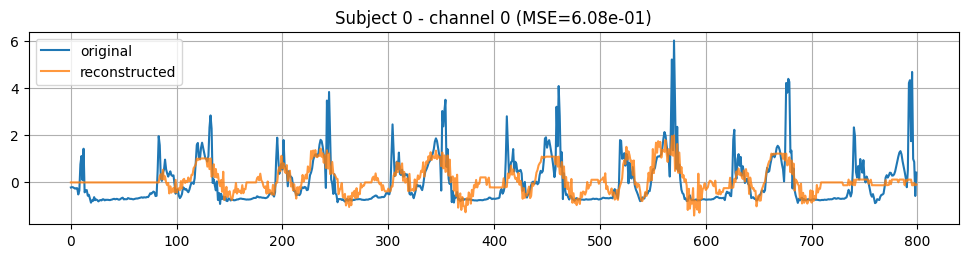

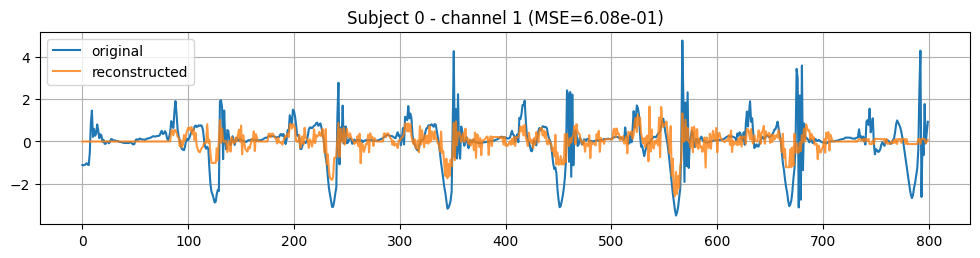

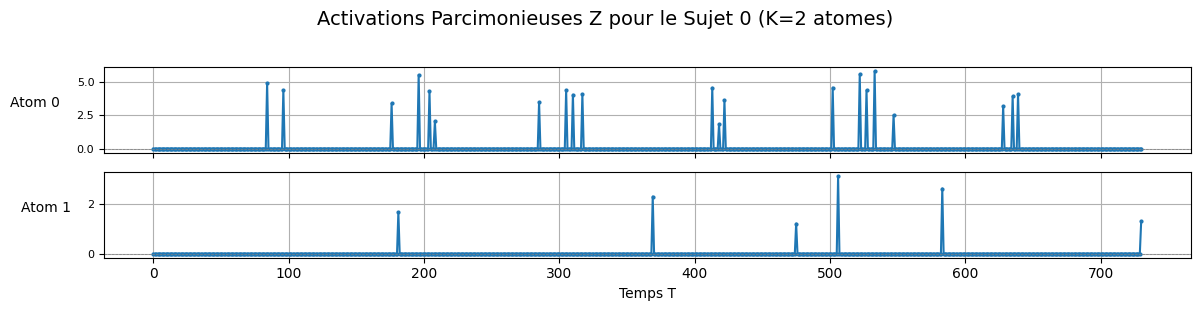

Atom norms: [0.99999994 0.99999994]
MSE median: 5.712171e-01, mean: 5.895666e-01


In [393]:
# S'assurer que les variables existent
try:
    _ = Phi
    _ = Z
    _ = X
except NameError:
    raise RuntimeError("Les tenseurs Phi, Z, X doivent être définis avant d'exécuter cette cellule.")

# Copier sur CPU pour la visualisation
Phi_cpu = Phi.detach().cpu()
Z_cpu = Z.detach().cpu()
X_cpu = X.detach().cpu()

S, N, P = X_cpu.shape
K, L, P_phi = Phi_cpu.shape

# quick NaN check
if torch.isnan(Phi_cpu).any() or torch.isnan(Z_cpu).any() or torch.isnan(X_cpu).any():
    print("Attention : NaN détecté dans Phi / Z / X !")

# 1) Afficher les atomes (par canal)
fig, axs = plt.subplots(K, P, figsize=(4*P, 2*K))
for k in range(K):
    for p in range(P):
        if K == 1 and P == 1:
            ax = axs
        elif K == 1:
            ax = axs[p]
        elif P == 1:
            ax = axs[k]
        else:
            ax = axs[k, p]
        ax.plot(np.arange(L), Phi_cpu[k, :, p])
        ax.set_title(f'Atom {k} - chan {p}')
plt.tight_layout()
plt.show()

# 2) Reconstruction pour quelques sujets et calcul des MSE
n_display = min(1, S)
for s in range(n_display):
    z_s = Z_cpu[s].unsqueeze(0)  # 1 x K x T
    phi_conv = Phi_cpu.permute(0, 2, 1)  # K x P x L
    recon = F.conv_transpose1d(z_s, phi_conv, padding=0).squeeze(0).permute(1, 0)  # N x P
    recon = recon.numpy()
    x_s = X_cpu[s].numpy()

    if recon.shape != x_s.shape:
        print(f"Warning shape mismatch for subject {s}: recon {recon.shape} vs x {x_s.shape}")

    mse = ((x_s - recon) ** 2).mean()
    print(f'Subject {s} MSE: {mse:.6e}')

    for p in range(P):
        plt.figure(figsize=(12, 2.5))
        plt.plot(x_s[:, p], label='original')
        plt.plot(recon[:, p], label='reconstructed', alpha=0.8)
        plt.title(f'Subject {s} - channel {p} (MSE={mse:.2e})')
        plt.legend()
        plt.show()

# 3) Heatmap des activations Z (K x T) pour les mêmes sujets
T = Z_cpu.shape[2]
time_axis = np.arange(T)

for s in range(n_display):
    K = Z_cpu.shape[1] # Récupérer K
    
    # Définir la grille de subplots (K lignes, 1 colonne)
    # Taille ajustée pour avoir de la hauteur pour K courbes
    fig, axs = plt.subplots(K, 1, figsize=(12, 1.5 * K), sharex=True)
    
    if K == 1: # Gérer le cas K=1
        axs = [axs]
        
    for k in range(K):
        ax = axs[k]
        
        # Plot des activations pour l'atome k du sujet s
        # Z_cpu[s] est de forme (K, T)
        activations_k = Z_cpu[s, k, :].numpy()
        
        # On utilise stem ou plot avec des marqueurs discrets pour mieux voir les "diracs"
        # La fonction plot simple est souvent suffisante si la parcimonie est forte
        ax.plot(time_axis, activations_k, marker='.', linestyle='-', markersize=4, label=f'Atom {k}')
        
        # Mettre en évidence la non-négativité
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        
        # Titre pour l'axe Y
        ax.set_ylabel(f'Atom {k}', rotation=0, labelpad=30, fontsize=10)
        ax.tick_params(axis='y', labelsize=8)
        
        # Optionnel: définir l'axe y pour mieux visualiser les pics (si max(Z) est grand)
        # max_val = Z_cpu[s].max().item()
        # ax.set_ylim(-0.1 * max_val, max_val * 1.1)

    # Titre général et étiquette X
    fig.suptitle(f'Activations Parcimonieuses Z pour le Sujet {s} (K={K} atomes)', fontsize=14, y=1.02)
    axs[-1].set_xlabel('Temps T')
    
    plt.tight_layout(rect=[0, 0, 1, 1]) # Ajuster pour le suptitle
    plt.show()

# 4) Normes des atomes
norms = Phi_cpu.view(K, -1).norm(p=2, dim=1).numpy()
print('Atom norms:', norms)

# 5) Statistiques globales
recons = []
mses = []
for s in range(S):
    z_s = Z_cpu[s].unsqueeze(0)
    recon = F.conv_transpose1d(z_s, Phi_cpu.permute(0, 2, 1), padding=0).squeeze(0).permute(1, 0).numpy()
    x_s = X_cpu[s].numpy()
    if recon.shape == x_s.shape:
        mses.append(((x_s - recon) ** 2).mean())

if len(mses) > 0:
    print(f"MSE median: {np.median(mses):.6e}, mean: {np.mean(mses):.6e}")
else:
    print("Pas de MSE calculée (shape mismatch partout).")



📊 MSE par canal
Canal 0: original=5.840e-01, warped=5.310e-01
Canal 1: original=6.312e-01, warped=5.583e-01


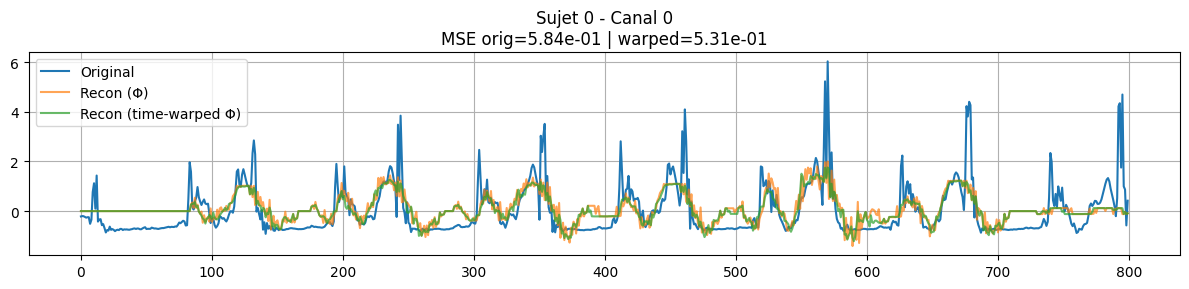

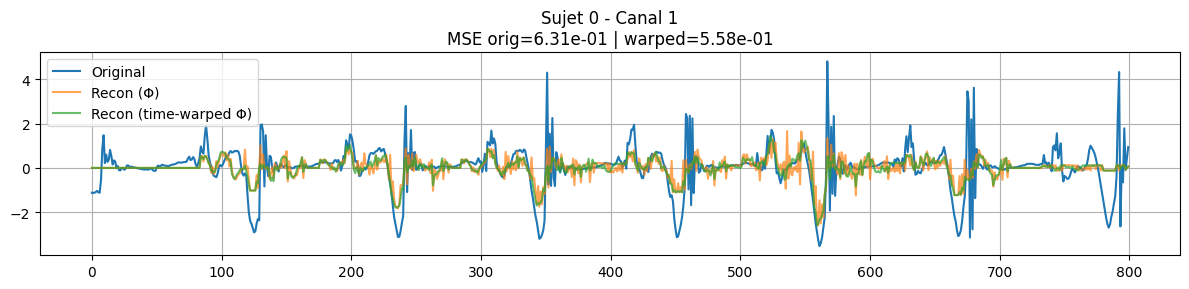

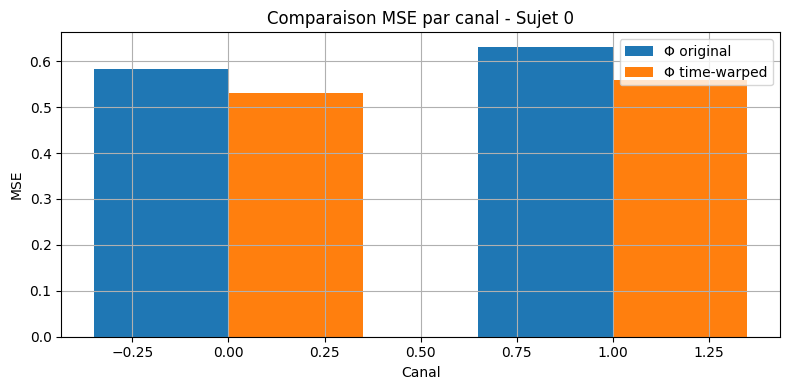

In [394]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# ⚙️ Hypothèses : ces tenseurs sont déjà définis
# ------------------------------------------------------------
# X:   (S, N, P)
# Z:   (S, K, T)
# Phi: (K, L, P)
# A:   (S, K, M)
# time_warping_f(phi_k, a_k_s): -> (L, P)
# ------------------------------------------------------------

device = X.device
S, N, P = X.shape
K, L, P_phi = Phi.shape
assert P == P_phi

# Sujet à visualiser
s = 0  # patient 1

x_s = X[s].detach().cpu().numpy()  # (N, P)
z_s = Z[s].unsqueeze(0).to(device)  # (1, K, T)
a_s = A[s].to(device)               # (K, M)

# ------------------------------------------------------------
# 🧱 Reconstruction avec Phi original
# ------------------------------------------------------------
phi_conv = Phi.permute(0, 2, 1).to(device)  # (K, P, L)
recon_orig = (
    F.conv_transpose1d(z_s, phi_conv, padding=0)
    .squeeze(0)
    .permute(1, 0)
    .detach()
    .cpu()
    .numpy()
)  # (N, P)

# ------------------------------------------------------------
# 🧠 Reconstruction avec Phi "time-warped"
# ------------------------------------------------------------
warped_phis = []
for k in range(K):
    phi_k = Phi[k].to(device)  # (L, P)
    a_k_s = a_s[k]             # (M,)
    warped_phi_k = time_warping_f(phi_k, a_k_s)  # (L, P)
    warped_phis.append(warped_phi_k.unsqueeze(0))
Phi_warped = torch.cat(warped_phis, dim=0)  # (K, L, P)

phi_conv_warped = Phi_warped.permute(0, 2, 1)
recon_warped = (
    F.conv_transpose1d(z_s, phi_conv_warped, padding=0)
    .squeeze(0)
    .permute(1, 0)
    .detach()
    .cpu()
    .numpy()
)  # (N, P)

# ------------------------------------------------------------
# 📏 MSE par canal
# ------------------------------------------------------------
mse_per_channel_orig = ((x_s - recon_orig) ** 2).mean(axis=0)  # (P,)
mse_per_channel_warped = ((x_s - recon_warped) ** 2).mean(axis=0)  # (P,)

print("\n📊 MSE par canal")
for p in range(P):
    print(f"Canal {p}: original={mse_per_channel_orig[p]:.3e}, warped={mse_per_channel_warped[p]:.3e}")

# ------------------------------------------------------------
# 🎨 Visualisation par canal
# ------------------------------------------------------------
for p in range(P):
    plt.figure(figsize=(12, 3))
    plt.plot(x_s[:, p], label='Original', linewidth=1.5)
    plt.plot(recon_orig[:, p], label='Recon (Φ)', alpha=0.7)
    plt.plot(recon_warped[:, p], label='Recon (time-warped Φ)', alpha=0.7)
    plt.title(
        f'Sujet {s} - Canal {p}\n'
        f'MSE orig={mse_per_channel_orig[p]:.2e} | warped={mse_per_channel_warped[p]:.2e}'
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 📊 Visualisation globale : barplot des MSE
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
x_axis = np.arange(P)
bar_width = 0.35
plt.bar(x_axis - bar_width/2, mse_per_channel_orig, width=bar_width, label='Φ original')
plt.bar(x_axis + bar_width/2, mse_per_channel_warped, width=bar_width, label='Φ time-warped')
plt.xlabel('Canal')
plt.ylabel('MSE')
plt.title(f'Comparaison MSE par canal - Sujet {s}')
plt.legend()
plt.tight_layout()
plt.show()
